# <div style="text-align: center">18.335/6.337 Problem Set 3 - Orthogonal Triangularization and Projectors</div>
## <div style="text-align: center">Solutions</div>

### <div style="text-align: right">Creaed by Wonseok Shin</div>

$\newcommand{\Cm}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cv}[1]{\mathbb{C}^{#1}}\newcommand{\Rm}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rv}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}$

## General instructions
- Please archive all files (this Jupyter notebook plus other files if any) into a single ZIP file and upload it to the course website, so that the grader can run the Jupyter notebook in the extracted folder without adding anything.  (This greatly simplifies the grader's job.)
- Some questions may require proofs or explanations, and there are a few options to submit them electronically.
    1. Ideally, write down your proofs or explanations in the corresponding sections of this Jupyter notebook.  You can use $\LaTeX$ commands for mathematical symbols, like $A = \hat{U} \Sigma V^*$, $\sum_{j = 1}^{r} \sigma_j u_j v_j^*$, and $\left[
\begin{array}{cc}
 1 & 2 \\
 3 & 4 \\
\end{array}
\right]$.
    2. If you are not familiar with $\LaTeX$ commands, you can use any word processors with equation editors.  If you choose to use this option, make sure to convert the word processor file into PDF before submission.
    3. If none of the above works for you, you can also submit a scan of your handwritten notes as a last resort, but your handwriting must be clear and readable.
- The score of bonus problems, if any, will be added to your total problem set score at the end of the semester.  However, your total problem set score cannot exceed the perfect problem set score without bonus problems.  In other words, 
$$
\text{your total p-set score} = \min\left\{\sum_n\text{your $n$th p-set score $with$ bonus problems}, \sum_n\text{perfect $n$th p-set score $without$ bonus problems}\right\}.
$$
So solve bonus problems to compensate for the deducted points in your problem sets.

## Problem 1.  Householder QR factorization [5 pts]

(Partly taken from Exercise 10.2 of Trefethen and Bau)

In this problem, we will implement the Householder QR factorization (modification of Alg. 10.1).  In addition, we will implement a function to apply $Q$ or $Q^*$ on a given matrix implicitly (modification of Algs. 10.2 and 10.3).

We will implement these functions to operate on input matrices "in-place".  For example, we will write the Householder QR factorization such that it triangularizes $A$ into $R$ "in-place" without creating a separate matrix for $R$: the input argument $A$ will be overwritten by $R$.  This is useful when your matrix is large because it saves memory.  In fact, all the Algs. 10.1–3 in the textbook are written in this in-place style.  

Julia's convention for such functions that modify the input arguments is to [append `!` to function names](http://docs.julialang.org/en/stable/manual/style-guide/#append-to-names-of-functions-that-modify-their-arguments).  For example, for a vector `x`, `sort(x)` returns a separate vector containing the sorted vector, whereas `sort!(x)` sorts `x` itself:

In [1]:
x = [2, 4, 1, 3]
y = sort(x)
println("y = $y")

x = [2, 4, 1, 3]
sort!(x)  # overwrite x
println("x = $x")

y = [1,2,3,4]
x = [1,2,3,4]


Also note that you don't lose much by implementing in-place operations, because then you get out-of-place operations almost for free.  For example, the above `sort` can be easily implemented as `sort(x) = sort!(copy(x))`, and this is basically how Julia implements `sort`; see the source code of `sort` [here](https://github.com/JuliaLang/julia/blob/v0.5.1/base/sort.jl#L418).

### Assignment 1.1.  house! [2 pts]

Complete `house!` below that performs the in-place Householder QR factorization described in Alg. 10.1 of Trefethen and Bau.  Unlike Alg. 10.1, the function must handle rank-deficient $A$ as well.

The function takes two input arguments `V` and `A`.  Assume 
- `V` is a matrix of the same size as `A` and is initially filled with zeros, and
- `A` is square or skinny.

After execution of `house!(V, A)`, 
- the lower-triangular portion of `V` stores the unit vectors $\hat{v}$ used for Householder reflectors, i.e., $V_{k:m,k} = \hat{v}_k$, and
- `A` stores the $R$ factor of the full QR factorization $A = Q R$.

Do not create any $m\times n$ matrices inside `house!(V, A)`; avoiding creation of large arrays is the whole purpose of implementing in-place operations.

`house!` does not need to `return` anything, because the outputs are stored in the input arguments.

In [2]:
function house!(V, A)
    assert(size(V)==size(A))
    
    m, n = size(A)

    for k = 1:n
        x = @view A[k:m, k]
        
        # Construct sign(x₁) for exp(iθ) = -sign(x₁).
        s = sign(x[1])
        if s == 0
            s = 1.
        end

        # Construct the kth Houreholder reflection vector.
        v = @view V[k:m, k]
        copy!(v, x)
        lx = norm(x)
        slx = s * lx
        v[1] = v[1] + slx
        
        # Perform the Householder reflection to triangularize the kth column of A.
        lv = norm(v)
        if lv ≠ 0
            v ./= lv
            
            # Take care of the kth column of A.
            A[k+1:m, k] .= 0
            A[k,k] = -slx
            
            # Take care of the remaining columns of A.
            if k < n
                A[k:m, k+1:n] .-= v * (2(v' * @view A[k:m, k+1:n]))
            end
        end
    end
end

house! (generic function with 1 method)

### Validation of your implementation

Use the following code blocks to validate your implementation of `house!`:

In [3]:
# For full-rank A
m, n = 5, 3
A = rand(Complex128, m, n)

R = copy(A)
V = zeros(Complex128, m, n)

house!(V, R)

println("V lower-triangular?  $(istril(V))")
println("R upper-triangular?  $(istriu(R))")

for j = 1:n
    println("‖V[:,$j]‖ ≈ 1?  $(norm(V[:,j]) ≈ 1)")
end

for j = 1:n
    println("‖A[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(A[:,j]) ≈ norm(R[:,j]))")
end

V lower-triangular?  true
R upper-triangular?  true
‖V[:,1]‖ ≈ 1?  true
‖V[:,2]‖ ≈ 1?  true
‖V[:,3]‖ ≈ 1?  true
‖A[:,1]‖ ≈ ‖R[:,1]‖?  true
‖A[:,2]‖ ≈ ‖R[:,2]‖?  true
‖A[:,3]‖ ≈ ‖R[:,3]‖?  true


In [4]:
# For rank-deficient A
A = [1 0 0; 1 0 0; 1 0 0; 0 1 0]
m, n = size(A)

R = similar(A, Float64)
copy!(R, A)
V = zeros(size(A))

house!(V, R)

println("V lower-triangular?  $(istril(V))")
println("R upper-triangular?  $(istriu(R))")

for j = 1:n-1
    println("‖V[:,$j]‖ ≈ 1?  $(norm(V[:,j]) ≈ 1)")
end
println("‖V[:,3]‖ ≈ 0?  $(norm(V[:,3]) ≈ 0)")

for j = 1:n
    println("‖A[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(A[:,j]) ≈ norm(R[:,j]))")
end

V lower-triangular?  true
R upper-triangular?  true
‖V[:,1]‖ ≈ 1?  true
‖V[:,2]‖ ≈ 1?  true
‖V[:,3]‖ ≈ 0?  true
‖A[:,1]‖ ≈ ‖R[:,1]‖?  true
‖A[:,2]‖ ≈ ‖R[:,2]‖?  true
‖A[:,3]‖ ≈ ‖R[:,3]‖?  true


### Assignment 1.2.  `applyQhouse!` [1 pts]

Complete `applyQhouse!` below that multiplies $Q$ or $Q^*$ implicitly to a given matrix $X$.  The function generalizes Algs. 10.2 and 10.3 of the textbook from a column vector $x$ (or $b$ in Alg. 10.2) to a matrix $X$, so that we can use the function to multiply $Q$ to $R$, which is a matrix, to form $A$.  Also, we will implement Algs. 10.2 and 10.3 in this single function because the two algorithms are very simialr.

The function takes two mandatory input arguments `V` and `X`.  Assume
- `V` is produced by `house!`, and
- `X` has the same number of rows as `V` and any number of columns (i.e., $X \in \Cm{m}{p}$ for $V \in \Cm{m}{n}$).

In addition, the function takes the third, optional argument `isconj`.  This argument controls which of $Q$ and $Q^*$ to apply: $Q$ for `isconj = false` (the default value), and $Q^*$ otherwise.


After execution of `applyQhouse!(V, X, isconj)`,
- `V` remains the same as before, and
- `X` stores $Q X$ or $Q^* X$ depending on the value of `isconj`.

`applyQhouse!` does not need to `return` anything, because the outputs are stored in the input arguments.

In [5]:
function applyQhouse!(V, X, isconj=false)
    m, n = size(V)
    assert(size(X,1) == m)

    ks = isconj ? (1:n) : (n:-1:1)  # change application order depending on isconj

    for k = ks
        v = @view V[k:m, k]
        X[k:m,:] .-= v * (2(v' * @view X[k:m,:]))
    end
end

applyQhouse! (generic function with 2 methods)

### Validation of your implementation

Use the following code block to validate you implementation of `applyQhouse!`:

In [6]:
m, n = 10, 7
A = rand(Complex128, m, n)

R = copy(A)
V = zeros(Complex128, m, n)

house!(V, R)

QR = copy(R)
applyQhouse!(V, QR)
println("QR ≈ A?  $(QR ≈ A)")

Q = eye(Complex128, m)
Qc = eye(Complex128, m)
applyQhouse!(V, Q)
applyQhouse!(V, Qc, true)
println("Qc ≈ Q'?  $(Qc ≈ Q')")
println("Qc Q ≈ I?  $(Qc * Q ≈ eye(m))")

QR ≈ A?  true
Qc ≈ Q'?  true
Qc Q ≈ I?  true


### Assignment 1.3.  `applyQhouse!` vs. direct multiplication of $Q$ [2 pts]

It may seem that not producing $Q$ explicitly is a disadvantage of the Householder QR factorization compared to the Gram–Schmidt procedure.  On the contrary, this can be actually an advantage, because `applyQhouse!` is in general a faster way to multiply $Q$ to a vector than direct multiplication of explicitly constructed $Q$.  Let's see why this is the case.

(a) [1 pt] Let's compare the costs for the two operations in terms of the number of flops.
- Derive the asymptotic number of flops needed for executing `applyQhouse!` for $V \in \Rm{m}{n}$ and $x \in \Rv{m}$ with $m \ge n$.  (We consider real matrices and vectors here, because we will perform numerical experiments for them later.)  
- Assuming we have an explicitly constructed $Q$ matrix, derive the asymptotic number of flops needed for performing $Q x$.
- Comparing the numbers of flops, how much speedup do you expect to get by using `applyQhouse!(V, x)` instead of $Q x$?  Answer this question by expressing the speedup factor as a function of $n/m$, and implement it as a Julia function `spdup_flop(rnm)` below, where `rnm` is the ratio $n/m$.
- In what condition is the speedup factor minimized to what value?

*Solution*.

For a given $k$ in the for loop, `applyQhouse!` takes 

- $m-k+1$ multiplications and $m-k$ additions for $\alpha = \hat{v}_k^* x_{k:m}$,
- $1$ scalar multiplication for $\beta = 2\alpha$, 
- $m-k+1$ multiplications for $w = \hat{v}_k \beta$,
- $m-k+1$ subtractions for $y = x_{k:m}-w$,

which are $4(m-k+1)$ flops in total.  Summing these up for all $k$, it takes

$$
\sum_{k=n}^{1} 4(m-k+1) = 4\cdot\frac{n [(m-n+1)+m]}{2} \sim 2n (2m-n)
$$

flops in total.

In comparison, calculating each entry of $Q x$ takes $m$ multiplications and $m-1$ additions, or $\sim 2m$ flops in total.  Because $Q x$ has $m$ such entries, the entire $Q x$ takes $\sim 2m^2$ flops.

By comparing the numbers of flops required by the two operations, we expect a speedup factor of

$$
\frac{2m^2}{2n(2m-n)} = \frac{1}{\frac{n}{m}\left(2-\frac{n}{m}\right)}
$$

by using `applyQhouse!` instead of $Qx$.

Because $0 < \frac{n}{m} \le 1$, the two factors in the denominator of the above expression are both positive, so we can use the [AM–GM inequality](https://en.wikipedia.org/wiki/Inequality_of_arithmetic_and_geometric_means) to find the maximum of the denominator:

$$
\frac{n}{m}\left(2-\frac{n}{m}\right) \le \left[\frac{\frac{n}{m} + \left(2-\frac{n}{m}\right)}{2}\right]^2 = 1,
$$

where the equality holds when $\frac{n}{m} = 2-\frac{n}{m}$, or $m = n$ equivalently.  Therefore, the speedup factor is minimized to $1$ when $m = n$.


In [7]:
spdup_flop(rnm) = 1 / (rnm * (2-rnm))

spdup_flop (generic function with 1 method)

(b) [0.5 pts] Complete `spdup_time` below that measures the actual speedup factor for a given $V$ by numerical experiment.  
- To measure the actual speedup factor, take the ratio between the times taken for `applyQhouse!` and $Q x$.  (Use `@elapsed`.)
- To perform $Q x$, you will need to construct $Q$ explicitly first using `applyQhouse!`.  
- Because computation time fluctuates wildly from execution to execution, perform $N = 20$ measurments of this ratio and return the median value to ignore outliers.

In [8]:
function spdup_time(V, x)
    N = 20
    rt = Vector{Float64}(N)

    # Construct Q explicitly.
    m = size(V, 1)    
    T = eltype(V)
    Q = eye(T, m)
    applyQhouse!(V, Q)
    
    # Perform measurements.
    for k = 1:N
        t_mult = @elapsed Q*x
        t_apply = @elapsed applyQhouse!(V, copy(x))

        rt[k] = t_mult / t_apply
    end
    
    return median(rt)
end    

spdup_time (generic function with 1 method)

(c) [0.5 pts] The code block below plots the actual speedup factors measured by `spdup_time` for $V \in \Rm{m}{n}$ with $m = 50$ for $n$ between $1$ and $m$, and compare them with the theoretical speedup factors estimated by `spdup_flop`.  However, you will notice a huge mismatch between the expected theoretical speedup and the actual measurment.  Explain why this is the case.  

Also, modify one line of the code block to fix the mismatch and explain why it fixes the mismatch.

(Note: even after the fix, you don't have to get a perfect agreement between the theory and measurment, because 
- our flop estimation is only asymptotic,
- the number of flops is an inaccurate measure of computational cost that does not distinguish different arithmetic operations,
- actual performance depends on not only flops, but also other aspects of computation (e.g., memory bandwidth),
- the measurment overestimates the computation time because it does not exclude the time taken for initialization,

and so on.)

*Solution*.

The initial plot produced by the code block below shows that the measured speedup factors are not as great as what we expected from comparing the numbers of flops.  We can suspect that this happens because $Q x$, which is a built-in function of Julia, is a highly optimized piece of code.  Then, each flop in $Q x$ could be much faster than each flop in `applyQhouse!`.  As a result, even though $Q x $ took more flops than `applyQhouse!`, it could take less time.  

Therefore, for a fair comparison between the measurement and theory, we would need to compensate this difference in single flop's execution time.  In other words, we would need to "normalize" the output of `spdup_time` appropriately.

To figure out how to obtain the normalization factor, suppose `applyQhouse!` and `Q*x` take $f(m,n)$ and $g(m,n)$ flops, respectively.  The theoretical speedup factor is then $r_\mathrm{theory}(m,n) = \frac{g(m,n)}{f(m,n)}$.  However, because the code implementing the algorithm for `Q*x` is more optimized than the code implementing the algorithm for `applyQhouse!`, a single flop takes different amounts of time in the two pieces of code.  Suppose that a single flop takes $\alpha$ and $\beta$ seconds in the codes for `applyQhouse!` and `Q*x`, respectively.  Then the measured speedup factor is $r_\mathrm{measurment}(m,n) = \frac{\beta\, g(m,n)}{\alpha\, f(m,n)} = \frac{\beta}{\alpha} r_\mathrm{theory}(m,n)$.  Therefore, to get an agreement between the theoretical and measured speedup factors, we need to divide $r_\mathrm{measurement}(m,n)$ by $\frac{\beta}{\alpha}$.  

$\frac{\beta}{\alpha}$ can be easily obtained by comparing $r_\mathrm{theory}$ and $r_\mathrm{measurement}$ at specific values of $m$ and $n$.  The values we choose is the largest values of $m$ and $n$, because our $r_\mathrm{theory}$ is an asymptotic expression that becomes more accurate for larger $m$ and $n$.  Because $m$ is fixed, the largest $n$ is $n = m$.  Incidentally, from the previous question we know $r_\mathrm{theory} = 1$ for $n = m$. Therefore, $r_\mathrm{measurment}(m,m) = \frac{\beta}{\alpha} r_\mathrm{theory}(m,m) = \frac{\beta}{\alpha}$.  In other words, $\frac{\beta}{\alpha}$ is nothing but $r_\mathrm{measurment}$ measured for $n = m$, which is the last entry of `st` (the output of `stdup_time`) in the code below.

Indeed, dividing each entry of `st` by `st[end]`, we recover an excellent agreement between the theory and measurement as shown below.

An important implication of this result: even though `Q*x` won the speed race against `applyQhouse!`, it did not win the race by defying the required number of flops.  (If it had, we wouldn't have been able to match the two curves so well by simple normalization.)  Therefore, this result demonstrates that the operation count is the fundamental constraint imposed on a given algorithm, and extra speedup of the algorithm can be achieved only by making a single flop faster, not by reducing the operation count.  To reduce the operation count, you need to replace the algorithm (e.g., replace `Q*x` with `applyQhouse!`).

INFO: Recompiling stale cache file /Users/wsshin/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


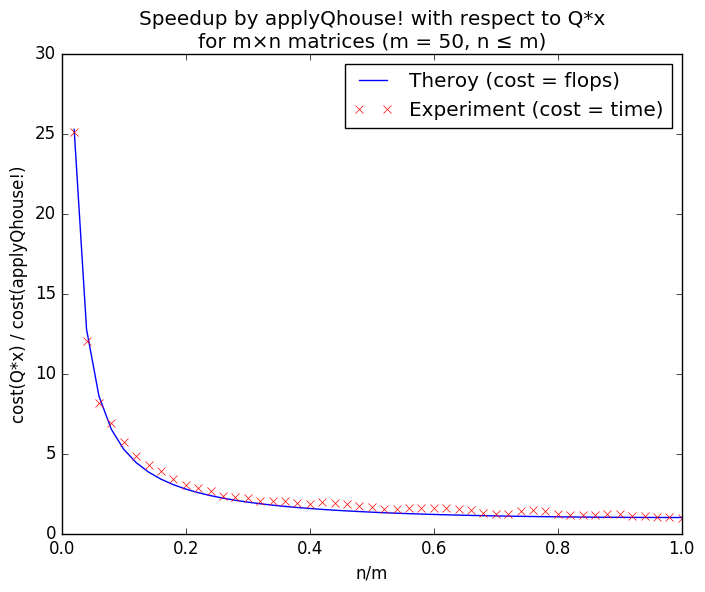

PyObject <matplotlib.legend.Legend object at 0x31916bef0>

In [9]:
m = 50
nmax = m

A = rand(m, nmax)
V = zeros(size(A))
house!(V, A)
x = rand(m)

st = Vector{Float64}(nmax)
for n = 1:nmax
    st[n] = spdup_time((@view V[:,1:n]), x)
end

using PyPlot
rnm = (1:nmax) ./ m

plot(rnm, spdup_flop.(rnm), "b-", rnm, st./st[end], "rx")  # change: st -> st./st[end]
title("Speedup by applyQhouse! with respect to Q*x\nfor m×n matrices (m = $m, n ≤ m)")
xlabel("n/m")
ylabel("cost(Q*x) / cost(applyQhouse!)")
legend(["Theroy (cost = flops)", "Experiment (cost = time)"], loc="upper right")

## Problem 2.  Givens QR factorization [3 pts]

The Givens QR factorization is another way to perform the QR factorization.  It is also an orthogonal triangularization method like the Householder QR factorization, but it shines when performing the QR factorization on an [upper Hessenberg matrix](https://en.wikipedia.org/wiki/Hessenberg_matrix), which is empty below the first subdiagonal.  (We will discuss this in class.)  

Note that like upper triangular matrices, upper Hessenberg matrices can be rectangular as well as square.  In this problem. we will specifically handle $(n+1)\times n$ upper Hessenberg matrices for simplicity.

### Assignment 2.1.  `givens!` [2 pts]

Complete `givens!` below that performs the in-place Givens QR factorization on an upper Hessenberg matrix $A\in \Cm{(n+1)}{n}$.  The function must handle rank-deficient $A$ as well.

The function takes three input arguments `c`, `s`, and `A`.  Assume 
- `c` and `s` are length-$n$ vectors initially filled with zeros, and
- `A` is an $(n+1)\times n$ upper Hessenberg matrix.

After execution of `givens!(c, s, A)`, 
- `c` and `s` stores the cosines and sines for $n$ Givens rotations, and
- `A` stores the $R$ factor of the full QR factorization $A = Q R$.

Do not create any $(n+1)\times n$ matrices or length-$n$ vectors inside `givens!(c, s, A)`; avoiding creation of large arrays is the whole purpose of implementing in-place operations.

`givens!` does not need to `return` anything, because the outputs are stored in the input arguments.

In [10]:
function givens!(c, s, A)
    m, n = size(A)
    assert(m == n+1)
    
    x = similar(A, 2)  # placeholder for length-2 vector to rotate
    G = similar(A, 2, 2)  # placeholder for Givens rotation
    
    for k = 1:n
        x[1], x[2] = A[k,k], A[k+1,k]
        
        # Construct and perform the Givens rotation to triangularize the kth column of A.
        lx = norm(x)
        if lx ≠ 0
            ck, sk = x[1]/lx, x[2]/lx
            G[1,1], G[1,2], G[2,1], G[2,2] = ck', sk', -sk, ck

            # Take care of the kth column A.
            A[k,k] = lx
            A[k+1,k] = 0
            
            # Take care of the remaining columns A.
            if k < n
                A[k:k+1, k+1:end] = G * (@view A[k:k+1, k+1:end])
            end
        else  # rank-deficient case
            ck, sk = one(x[1]), zero(x[2])  # c = 1, s = 0 (one, zero are different from ones, zeros)
        end

        c[k], s[k] = ck, sk
    end
end

givens! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of `givens!`:

In [11]:
# For full-rank A
n = 10
At = rand(Complex128, n+1, n)
A = triu(At, -1)

R = copy(A)
c = similar(A, n)
s = similar(A, n)

givens!(c, s, R)

println("R upper-triangular?  $(istriu(R))")
for j = 1:n
    println("‖A[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(A[:,j]) ≈ norm(R[:,j]))")
end

R upper-triangular?  true
‖A[:,1]‖ ≈ ‖R[:,1]‖?  true
‖A[:,2]‖ ≈ ‖R[:,2]‖?  true
‖A[:,3]‖ ≈ ‖R[:,3]‖?  true
‖A[:,4]‖ ≈ ‖R[:,4]‖?  true
‖A[:,5]‖ ≈ ‖R[:,5]‖?  true
‖A[:,6]‖ ≈ ‖R[:,6]‖?  true
‖A[:,7]‖ ≈ ‖R[:,7]‖?  true
‖A[:,8]‖ ≈ ‖R[:,8]‖?  true
‖A[:,9]‖ ≈ ‖R[:,9]‖?  true
‖A[:,10]‖ ≈ ‖R[:,10]‖?  true


In [12]:
# For rank-deficient A
A = [1 1 1; 1 1 1; 0 0 1; 0 0 1]
m, n = size(A)

R = similar(A, Float64)
copy!(R, A)
c = similar(R, n)
s = similar(R, n)

givens!(c, s, R)

println("R upper-triangular?  $(istriu(R))")
for j = 1:n
    println("‖A[:,$j]‖ ≈ ‖R[:,$j]‖?  $(norm(A[:,j]) ≈ norm(R[:,j]))")
end

R upper-triangular?  true
‖A[:,1]‖ ≈ ‖R[:,1]‖?  true
‖A[:,2]‖ ≈ ‖R[:,2]‖?  true
‖A[:,3]‖ ≈ ‖R[:,3]‖?  true


### Assignment 2.2.  `applyQgivens!` [1 pt]

Complete `applyQgivens!` below that multiplies $Q$ or $Q^*$ implicitly to a given matrix $X$.

The function takes three mandatory input arguments `c`, `s`, and `X`.  Assume
- `c` and `s` are length-$n$ vectors produced by `givens!`, and
- `X` has $n+1$ rows and any number of columns (i.e., $X \in \Cm{(n+1)}{p}$ for any $p$).

In addition, the function takes the fourth, optional argument `isconj`.  This argument controls which of $Q$ and $Q^*$ to apply: $Q$ for `isconj = false` (the default value), and $Q^*$ otherwise.


After execution of `applyQgivens!(c, s, X, isconj)`,
- `c` and `s` remain the same as before, and
- `X` stores $Q X$ or $Q^* X$ depending on the value of `isconj`.

`applyQgivens!` does not need to `return` anything, because the outputs are stored in the input arguments.

*Solution*.

The tricky part here compared to `applyQhouse!` is that unlike the Householder reflector $F$, the Givens rotation $G$ is not Hermitian ($F^* = F$ but $G^* \neq G$).  Therefore, when applying $Q$, you do not only have to reverse the order of the rotation matrices $G$, but also have to take the conjugate transpose of them.

In [13]:
function applyQgivens!(c, s, X, isconj=false)
    n = length(c)
    G = similar(c, 2, 2)  # placeholder for Givens rotation
    
    ks = isconj ? (1:n) : (n:-1:1)  # change application order depending on isconj

    for k = ks
        ck, sk = c[k], s[k]
        G[1,1], G[1,2], G[2,1], G[2,2] = isconj ? (ck', sk', -sk, ck) : (ck, -sk', sk, ck')
        X[k:k+1, :] = G * (@view X[k:k+1, :])
    end
end

applyQgivens! (generic function with 2 methods)

### Validation of your implementation

Use the following code block to validate your implementation of `applyQgivens!`:

In [14]:
n = 10
m = n+1
At = rand(Complex128, m, n)
A = triu(At, -1)

R = copy(A)
c = similar(A, n)
s = similar(A, n)

givens!(c, s, R)

QR = copy(R)
applyQgivens!(c, s, QR)
println("QR ≈ A?  $(QR ≈ A)")

Q = eye(Complex128, m)
Qc = eye(Complex128, m)
applyQgivens!(c, s, Q)
applyQgivens!(c, s, Qc, true)
println("Qc ≈ Q'?  $(Qc ≈ Q')")
println("Qc Q ≈ I?  $(Qc * Q ≈ eye(m))")

QR ≈ A?  true
Qc ≈ Q'?  true
Qc Q ≈ I?  true


## Problem 3.  Projectors [2 pts]

(a) [1 pt] Find all the eigenvalues of an arbitrary projector $P$ and their multiplicities.

*Solution*.

Suppose $\lambda$ is an eigenvalue of a projector $P \in \Cm{m}{m}$ corresponding to an eigenvector $x$, i.e., $P x = \lambda x$.  Then, because $P^2 = P$, we have
$$
\lambda x = P x = P^2 x = \lambda (P x) = \lambda^2 x.
$$
Because eigenvectors are nonzero, this means $\lambda = \lambda^2$, and thus $\lambda$ is either $1$ or $0$.

Now, observe that
- $P x = 1\cdot x$ for $x \in \range(P)$, and
- $P x = 0\cdot x$ for $x \in \null(P)$.

Therefore, we can choose $\rank(P)$ linearly independent $x$'s such that $P x = 1\cdot x$, and $\null(P)$ linearly independent $x$'s such that $P x = 0\cdot x$.  This means the geometric multiplicities of $\lambda = 1$ and $\lambda = 0$ are at least $\rank(P)$ and $\nullity(P)$, respectively.  Because $\rank(P) + \nullity(P) = m$, the total number of eigenvalues, we have counted all the multiplicities (meaning the algebraic multiplicities are the same as the geometric multiplicities).


(b) [1 pt] (Taken from Exercise 6.5 of Trefethen and Bau) Let $P \in \Cm{m}{m}$ be a nonzero projector.  Show that $\norm{P}_2 \ge 1$, with equality if and only if $P$ is an orthogonal projector.

*Proof*.

By definition, $\norm{P}_2 = \max_{x \neq 0} \frac{\norm{P x}_2}{\norm{x}_2}$.  Because $P \neq$, the dimension of $\range(P)$ is at least $1$, so there exists nonzero $z$ in $\range(P)$.  For such $z$, $P z = z$, and thus $\frac{\norm{P z}_2}{\norm{z}_2} = 1$.  Therefore, the maximum of the quotient $\frac{\norm{P x}_2}{\norm{x}_2}$ is at least $1$, which proves $\norm{P}_2 \ge 1$.

To show $\norm{P}_2 = 1$ if $P$ is an orthogonal projector, note that the SVD of an orthogonal projector is written $P = Q \Sigma Q^*$ for a unitary matrix $Q$ and a diagonal matrix $\Sigma$ with only $1$ and $0$ on the diagonal.  Furthermore, $\Sigma$ must have at least one $1$ on the diagonal for $P \neq 0$.  Therefore, $\norm{P}_2 = \sigma_\max(P) = 1$.

Conversely, to show $P$ is an orthogonal projector if $\norm{P}_2 = 1$, suppose that $P \in \Cm{m}{m}$ is *not* an orthogonal projector.  Our aim is to show that there exists $r \in \Cv{m}$ whose shadow $P r$ is longer than $r$ for this non-orthogonal projector $P$.  (If you draw an non-orthogonal projector in 2D, you will realize that this claim is pretty obvious.  Still, we need to prove it rigorously.)  This implies $\norm{P}_2 > 1$, which proves by contraposition that $P$ is an orthogonal projector if $\norm{P}_2 = 1$.

For convenience, define the set of shadows $S = \range(P)$ and the set of projection directions $D = \null(P)$.  Because $P$ is not an orthogonal projector, $S$ is not orthogonal to $D$.  However, we can easily find a subspace $D^\bot$ orthogonal to $D$.  ($D^\bot$ is called the [orthogonal complement](https://en.wikipedia.org/wiki/Orthogonal_complement) of $D$.)  Then, we can construct an *orthogonal* projector $R \in \Cm{m}{m}$ onto $D^\bot$ along $D$.  The two projectors $P$ and $R$ share $D$ as the set of projection directions, but their sets of shadows ($S$ and $D^\bot$) are different.  Note that $\dim(S) = m - \dim(D) = \dim(D^\bot)$.

We know there exists $s \in S$ such that $s \notin D^\bot$.  (If all $s \in S$ satisfy $s \in D^\bot$, then $S = D^\bot$ because $\dim(S) = \dim(D^\bot)$, but this is impossible because $S$ is not orthogonal to $D$.)  For such $s$, consider $r = R s$.  Because $R (r-s) = R^2 s - R s = 0$, we have $r - s \in D$, which implies $P(r - s) = 0$.  Therefore, $P r = P s = s$.  Note that $\norm{R s}_2 < \norm{s}_2$ because $s \notin \range(R)$ for an orthogonal projector $R$.  Therefore, we have found $r$ such that $\norm{r}_2 = \norm{R s}_2 < \norm{s}_2 = \norm{P r}$ as we originally aimed, which completes the proof.

## Bonus problem.  Orthogonal triangularization into $R$ with nonnegative diagonal [3 pts]

It is known that Julia's qr() implements the Householder QR factorization.  Indeed, our `house!` produces the same $Q$ and $R$ factors as Julia's `qr`:

In [15]:
m, n = 5, 3
T = Float64
A = rand(T, m, n)

Rh = copy(A)
Vh = zeros(T, m, n)

house!(Vh, Rh)

Qh = eye(T, m)
applyQhouse!(Vh, Qh)

Qj, Rj = qr(A, thin=false)

println("Qh ≈ Qj?  $(Qh ≈ Qj)")
println("Rh ≈ Rj?  $(Rh[1:n,:] ≈ Rj)")

Qh ≈ Qj?  true
Rh ≈ Rj?  true


However, this is the case only for real $A$.  For complex $A$, Julia's `qr` produces different $Q$ and $R$ factors than `house!`:

In [16]:
m, n = 5, 3
T = Complex128
A = rand(T, m, n)

Rh = copy(A)
Vh = zeros(T, m, n)

house!(Vh, Rh)

Qh = eye(T, m)
applyQhouse!(Vh, Qh)

Qj, Rj = qr(A, thin=false)

println("Qh ≈ Qj?  $(Qh ≈ Qj)")
println("Rh ≈ Rj?  $(Rh[1:n,:] ≈ Rj)")

Qh ≈ Qj?  false
Rh ≈ Rj?  false


What is the difference?  Let's print out the $R$ factors of the two functions:

In [17]:
Rh

5×3 Array{Complex{Float64},2}:
 -1.65683-0.040098im    -1.2859-0.0378073im   -1.27412-0.300061im
      0.0+0.0im       -0.194527+0.388928im    0.170655+0.553358im
      0.0+0.0im             0.0+0.0im        -0.527087+0.891035im
      0.0+0.0im             0.0+0.0im              0.0+0.0im     
      0.0+0.0im             0.0+0.0im              0.0+0.0im     

In [18]:
Rj

3×3 Array{Complex{Float64},2}:
 -1.65731+0.0im   -1.28643-0.00668451im   -1.28101-0.269146im
      0.0+0.0im  -0.434863+0.0im         -0.418567+0.400162im
      0.0+0.0im        0.0+0.0im          -1.03526+0.0im     

Here, we notice that Julia's `qr` produces $R$ (= `Rj`) with *real* diagonal entries even if $A$ is complex.  So, Julia must be using something else than the Householder reflection for orthogonal triangularization!

In this problem, we will mimic the behavior of Julia's `qr` and go one step further: we will transform `house!` into `housepos!` that produces $R$ with not just real diagonal, but completely nonnegative diagonal.

### Assignment B.1.  Non-Hermitian orthogonal triangularization [1 pt]

In the Householder QR factorization, the constraints we imposed on the matrix $F$ were as follows:
- $F$ must be unitary (in order to make $Q$ unitary).
- $F$ must transform a given column vector $x$ into a vector whose only nonzero entry is the first entry (in order to perform triangularization).  In other words, $F x = e^{i\theta} \norm{x} e_1$.

We showed that we could find such $F$ in the form of Householder reflector $F = I - 2 \hat{v}\hat{v}^*$.  Specifically, we showed that we could find a unit vector $\hat{v}$ such that $F$ is unitary and

$$
F x = (I - 2\hat{v}\hat{v}^*) x = e^{i\theta} \norm{x} e_1.
$$

In addition to satisfying the above two constraints, the Householder reflector has a very nice property of being Hermitian ($F^* = F$).  Though Hermiticity is a very desirable property in many cases, in the present context it is the source of our problem, because it constrains $e^{i\theta}$ to be $\pm \sign(x_1)$:  $e^{i\theta} \norm{x}$ becomes a diagonal entry of $R$, so when $e^{i\theta} =  \pm \sign(x_1)$, which is complex for complex $x_1$, the diagonal entry cannot be made real.

So, for our purpose, we would rather give up Hermiticity and achieve

$$
G x = \norm{x} e_1.
$$

If we used such $G$ instead of $F$ for orthogonal triangularization, the real and nonnegative $\left\|x\right\|$ would become a diagonal entry of $R$.

Find a unitary $G$ satisfying the above equation.  (Hint: it can be easily constructed using $F$.)

*Solution*.

The matrix is $G = e^{-i\theta} F$.  It is easy to verify this matrix satisfies the two conditions we want:
- $G x = e^{-i\theta} F x = \norm{x} e_1$, and 
- $G$ is unitary ($G^* G = F^* F = I$).

### Assignment B.2.  `housepos!` and `applyQhousepos!` [2 pts]

By using the above found $G$ instead of $F$, transform the previously written `house!` into `housepos!` below that orthogonally triangularizes a square or skinny $A$ into an upper-triangular $R$ with nonnegative real diagonal entries.  Also transform `applyQhouse!` into `applyQhousepos!` accordingly.

The new functions take the same input arguments as their old counterparts.  (Note: you may want to let `housepos!` output additional pieces of information, but all the necessary pieces of information are already contained in $V$.  Devise a way to retrieve them from $V$.)

*Solution*.

Once figuring out $G$, the implementation `housepos!` is straightforward: you just need to use $G$ instead of $F$.

When constructing $G$, we used not only $\hat{v}$ but also $e^{i\theta} = -\sign(x_1)$.  At first glance this seems to require us to store $\sign(x_1)$ as well as $\hat{v}$ in `housepos!` in order to use them to reconstruct $G$ later inside `applyQhousepos!`.  However, because $v = x + \sign(x_1) \norm{x} e_1$, the first entry of $v$ is

$$
v_1 = x_1 + \sign(x_1) \norm{x} = \sign(x_1) \abs{x_1} + \sign(x_1) \norm{x} = \sign(x_1) (\abs{x_1} + \norm{x}),
$$

and thus $\sign(x_1) = \sign(v_1) = \sign(\hat{v}_1)$.  Therefore, we can retrieve $\sign(x_1)$ from $\hat{v}$ without having to store it separately.

Also, you need to be a bit careful when implementing `applyQhousepos!`, because, unlike $F$, now $G$ is no longer Hermitian.  Because $G$ is not Hermitian, $Q_k$'s are not Hermitian, either.  Therefore, from $Q^* = Q_n \cdots Q_1$, we have $Q = Q_1^* \cdots Q_n^*$ rather than $Q = Q_1 \cdots Q_n$.  (In fact, the same issue was already discussed when implementing `applyQgivens!`, where the Givens rotation was not Hermitian.)  Still, code does not change too much from `applyQhouse!` because $G^* = (e^{-i\theta}F)^* = e^{i\theta} F$.  This means `applyQhousepos!` uses $F$ for both $Q$ and $Q^*$ as `applyQhouse!` did, and the only change is to multiply either $e^{-i\theta}$ or $e^{i\theta}$ depending on the value of `isconj`.

In [19]:
function housepos!(V, A)
    assert(size(V)==size(A))
    
    m, n = size(A)

    for k = 1:n
        x = @view A[k:m, k]

        # Construct sign(x₁) for exp(iθ) = -sign(x₁).
        s = sign(x[1])
        if s == 0
            s = -1.  # any s = exp(iθ) is acceptible, but s = -1 saves computation a bit below
        end

        # Construct the kth Houreholder reflection vector.
        v = @view V[k:m, k]
        copy!(v, x)
        lx = norm(x)
        slx = s * lx
        v[1] = v[1] + slx

        # Perform the Householder reflection to triangularize the kth column of A.
        lv = norm(v)
        if lv ≠ 0
            v ./= lv

            # Take care of the kth column of A.
            A[k+1:m, k] .= 0
            A[k,k] = lx

            # Take care of the remaining columns of A.
            if k < n
                A[k:m, k+1:n] .-= v * (2(v' * @view A[k:m, k+1:n]))
            end
        end
        
        # Apply exp(-iθ).
        if s ≠ -1 && k < n  # skip s = -1 because no effect in following
            A[k:m, k+1:n] ./= -s  # -s = exp(iθ), and 1/(-s) = exp(-iθ)
        end
    end
end

housepos! (generic function with 1 method)

In [20]:
function applyQhousepos!(V, X, isconj=false)
    m, n = size(V)
    assert(size(X,1) == m)
    
    ks = isconj ? (1:n) : (n:-1:1)  # change application order depending on isconj

    for k = ks
        # Perform the Householder reflection.
        v = @view V[k:m, k]
        X[k:m,:] .-= v * (2(v' * @view X[k:m,:]))

        # Apply exp(iθ).
        ms = -sign(v[1])  # ms = -s = -sign(x₁) = -sign(v₁)
        if ms ≠ 0 && ms ≠ 1
            X[k:m,:] .*= isconj ? 1/ms : ms
        end
    end
end

applyQhousepos! (generic function with 2 methods)

### Validation of your implementation

Use the following code block to validate your implementation of `housepos!` and `applyQhousepos!`:

In [21]:
m, n = 10, 7
A = rand(Complex128, m, n)

# Uncomment the following to test rank-deficient A
# A = Float64[1 0 0; 1 0 0; 1 0 0; 0 1 0]
# m, n = size(A)

R = copy(A)
V = zeros(Complex128, m, n)

housepos!(V, R)
println("R upper-triangular?  $(istriu(R))")
println("diag(R) real?  $(isreal(diag(R)))")
println("diag(R) nonnegative?  $(all(real(diag(R)).≥0))")

QR = copy(R)
applyQhousepos!(V, QR)
println("QR ≈ A?  $(QR ≈ A)")

Q = eye(Complex128, m)
Qc = eye(Complex128, m)
applyQhousepos!(V, Q)
applyQhousepos!(V, Qc, true)
println("Qc ≈ Q'?  $(Qc ≈ Q')")
println("Qc Q ≈ I?  $(Qc * Q ≈ eye(m))")

R upper-triangular?  true
diag(R) real?  true
diag(R) nonnegative?  true
QR ≈ A?  true
Qc ≈ Q'?  true
Qc Q ≈ I?  true
